In [31]:
import numpy as np
import numba #Librería que permite acelerar funciones de python mediante compilación just-in-time (JIT)
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import QuantLib as ql

In [36]:
@numba.jit(nopython=True)
def _tridiagonal_solve(a,b,c,d):
    n=len(d)
    cp=np.empty(n-1)
    dp=np.empty(n)
    cp[0]=c[0]/b[0]
    dp[0]=d[0]/b[0]
    for i in range(1,n-1):
        denom=b[i]-a[i-1]*cp[i-1]
        cp[i]=c[i]/denom
        dp[i]=(d[i]-a[i-1]*dp[i-1])/denom
    dp[n-1]=(d[n-1]-a[n-2]*dp[n-2])/(b[n-1]-a[n-2]*cp[n-2])
    x=np.empty(n)
    x[n-1]=dp[n-1]
    for i in range(n-2,-1,-1):
        x[i]=dp[i]-cp[i]*x[i+1]
    return x

@numba.jit(nopython=True)
def _tridiagonal_psor(aL, aD, aU, b, P_exercise, omega, P_guess, tol, max_iter):
    N = len(P_guess)
    P = np.copy(P_guess)
    P_old = np.empty_like(P)
    for k in range(max_iter):
        for i in range(N):
            P_old[i] = P[i]
        sigma = aU[0] * P_old[1]
        P_gs = (b[0] - sigma) / aD[0]
        P_sor = (1.0 - omega) * P_old[0] + omega * P_gs
        P[0] = max(P_sor, P_exercise[0])
        for i in range(1, N - 1):
            sigma = aL[i] * P[i-1] + aU[i] * P_old[i+1]
            P_gs = (b[i] - sigma) / aD[i]
            P_sor = (1.0 - omega) * P_old[i] + omega * P_gs
            P[i] = max(P_sor, P_exercise[i])
        sigma = aL[N-1] * P[N-2]
        P_gs = (b[N-1] - sigma) / aD[N-1]
        P_sor = (1.0 - omega) * P_old[N-1] + omega * P_gs
        P[N-1] = max(P_sor, P_exercise[N-1])
        error = 0.0
        for i in range(N):
            error = max(error, abs(P[i] - P_old[i]))
        if error < tol:
            return P, k + 1
    return P, max_iter

def _domain_from_L(K,sigma,T,L):
    xmin=np.log(K)-L*sigma*np.sqrt(T)
    xmax=np.log(K)+L*sigma*np.sqrt(T)
    return xmin,xmax

def _bc_arrays_full(is_call,american,K,r,q,Smin,Smax,tau_vec):
    if is_call:
        left=np.zeros_like(tau_vec)
        right=np.exp(-q*tau_vec)*Smax-K*np.exp(-r*tau_vec)
    else:
        left=K*np.ones_like(tau_vec) if american else K*np.exp(-r*tau_vec)
        right=np.zeros_like(tau_vec)
    return left,right

def solve_pde(K,T,r,sigma,q=0.0,is_call=False,american=True,M=200,N=1000,L=6.0,xmin=None,xmax=None,return_grid=False,method="implicit",american_method='projection'):
    if xmin is None or xmax is None:
        xmin,xmax=_domain_from_L(K,sigma,T,L)
    x=np.linspace(xmin,xmax,M+1)
    Z=np.exp(x)
    dx=(xmax-xmin)/M
    dt=T/N
    a=0.5*sigma*sigma
    b=r-q-0.5*sigma*sigma
    alpha=a*dt/(dx*dx)
    beta=b*dt/(2.0*dx)
    gamma=r*dt
    U=np.empty((N+1,M+1))
    payoff=np.maximum(Z-K,0.0) if is_call else np.maximum(K-Z,0.0)
    U[0]=payoff
    tau_vec=np.arange(N+1)*dt
    Smin=np.exp(xmin)
    Smax=np.exp(xmax)
    left_bc,right_bc=_bc_arrays_full(is_call,american,K,r,q,Smin,Smax,tau_vec)
    U[:,0]=left_bc
    U[:,-1]=right_bc
    if method=="explicit":
        a_star=( -beta + alpha )/(1.0+gamma)
        b_star=( 1.0 - 2.0*alpha )/(1.0+gamma)
        g_star=( beta + alpha )/(1.0+gamma)
        for n in range(N):
            U[n+1,1:-1]=a_star*U[n,0:-2]+b_star*U[n,1:-1]+g_star*U[n,2:]
            if american:
                U[n+1,1:-1]=np.maximum(U[n+1,1:-1],payoff[1:-1])
    elif method=="implicit":
        lower_coeffs = (beta - alpha)*np.ones(M-1)
        diag_coeffs = (1.0 + 2.0*alpha + gamma)*np.ones(M-1)
        upper_coeffs = (-(beta + alpha))*np.ones(M-1)
        aL = lower_coeffs.copy()
        aD = diag_coeffs.copy()
        aU = upper_coeffs.copy()
        aL[0] = 0.0
        aU[-1] = 0.0
        for n in range(N):
            rhs = U[n,1:-1].copy()
            rhs[0]  -= lower_coeffs[0] * U[n+1,0]
            rhs[-1] -= upper_coeffs[-1] * U[n+1,-1]
            if not american:
                U[n+1,1:-1] = _tridiagonal_solve(aL, aD, aU, rhs)
            else:
                if american_method == 'projection':
                    U_hold = _tridiagonal_solve(aL, aD, aU, rhs)
                    U[n+1,1:-1] = np.maximum(U_hold, payoff[1:-1])
                elif american_method == 'psor':
                    P_guess = U[n,1:-1]
                    P_exercise = payoff[1:-1]
                    U_sol, iters = _tridiagonal_psor(
                        aL, aD, aU, rhs,
                        P_exercise,
                        1.4, # Valor de omega típico para PSOR,
                        P_guess,
                        1e-8,
                        10000
                    )
                    U[n+1,1:-1] = U_sol
                else:
                    raise ValueError("american_method debe ser 'psor' o 'projection'")
    else:
        raise ValueError("method must be 'explicit' or 'implicit' per Hull's scheme")
    if return_grid:
        return Z,U[-1],U
    return Z,U[-1]

Iniciando simulación comparativa...
  Ejecutando para C = 0.03 (M=3036)...
    [WARN] Explícito divergente para C=0.03. Se omite el dato.


C:\Users\tomas\AppData\Local\Temp\ipykernel_3612\78464238.py:87: RuntimeWarning: overflow encountered in multiply
  U[n+1,1:-1]=a_star*U[n,0:-2]+b_star*U[n,1:-1]+g_star*U[n,2:]
C:\Users\tomas\AppData\Local\Temp\ipykernel_3612\78464238.py:87: RuntimeWarning: overflow encountered in add
  U[n+1,1:-1]=a_star*U[n,0:-2]+b_star*U[n,1:-1]+g_star*U[n,2:]
C:\Users\tomas\AppData\Local\Temp\ipykernel_3612\78464238.py:87: RuntimeWarning: invalid value encountered in add
  U[n+1,1:-1]=a_star*U[n,0:-2]+b_star*U[n,1:-1]+g_star*U[n,2:]


  Ejecutando para C = 0.05 (M=1518)...
    [WARN] Explícito divergente para C=0.05. Se omite el dato.
  Ejecutando para C = 0.10 (M=759)...
    [WARN] Explícito divergente para C=0.10. Se omite el dato.
  Ejecutando para C = 0.10 (M=759)...
    [WARN] Explícito divergente para C=0.10. Se omite el dato.
  Ejecutando para C = 0.25 (M=304)...
  Ejecutando para C = 0.50 (M=152)...
  Ejecutando para C = 1.00 (M=76)...
  Ejecutando para C = 0.25 (M=304)...
  Ejecutando para C = 0.50 (M=152)...
  Ejecutando para C = 1.00 (M=76)...
  Ejecutando para C = 2.00 (M=38)...
  Ejecutando para C = 5.00 (M=16)...
  Ejecutando para C = 2.00 (M=38)...
  Ejecutando para C = 5.00 (M=16)...
Valor de referencia (QuantLib FD): 11.76174708
Simulación completada.
Valor de referencia (QuantLib FD): 11.76174708
Simulación completada.


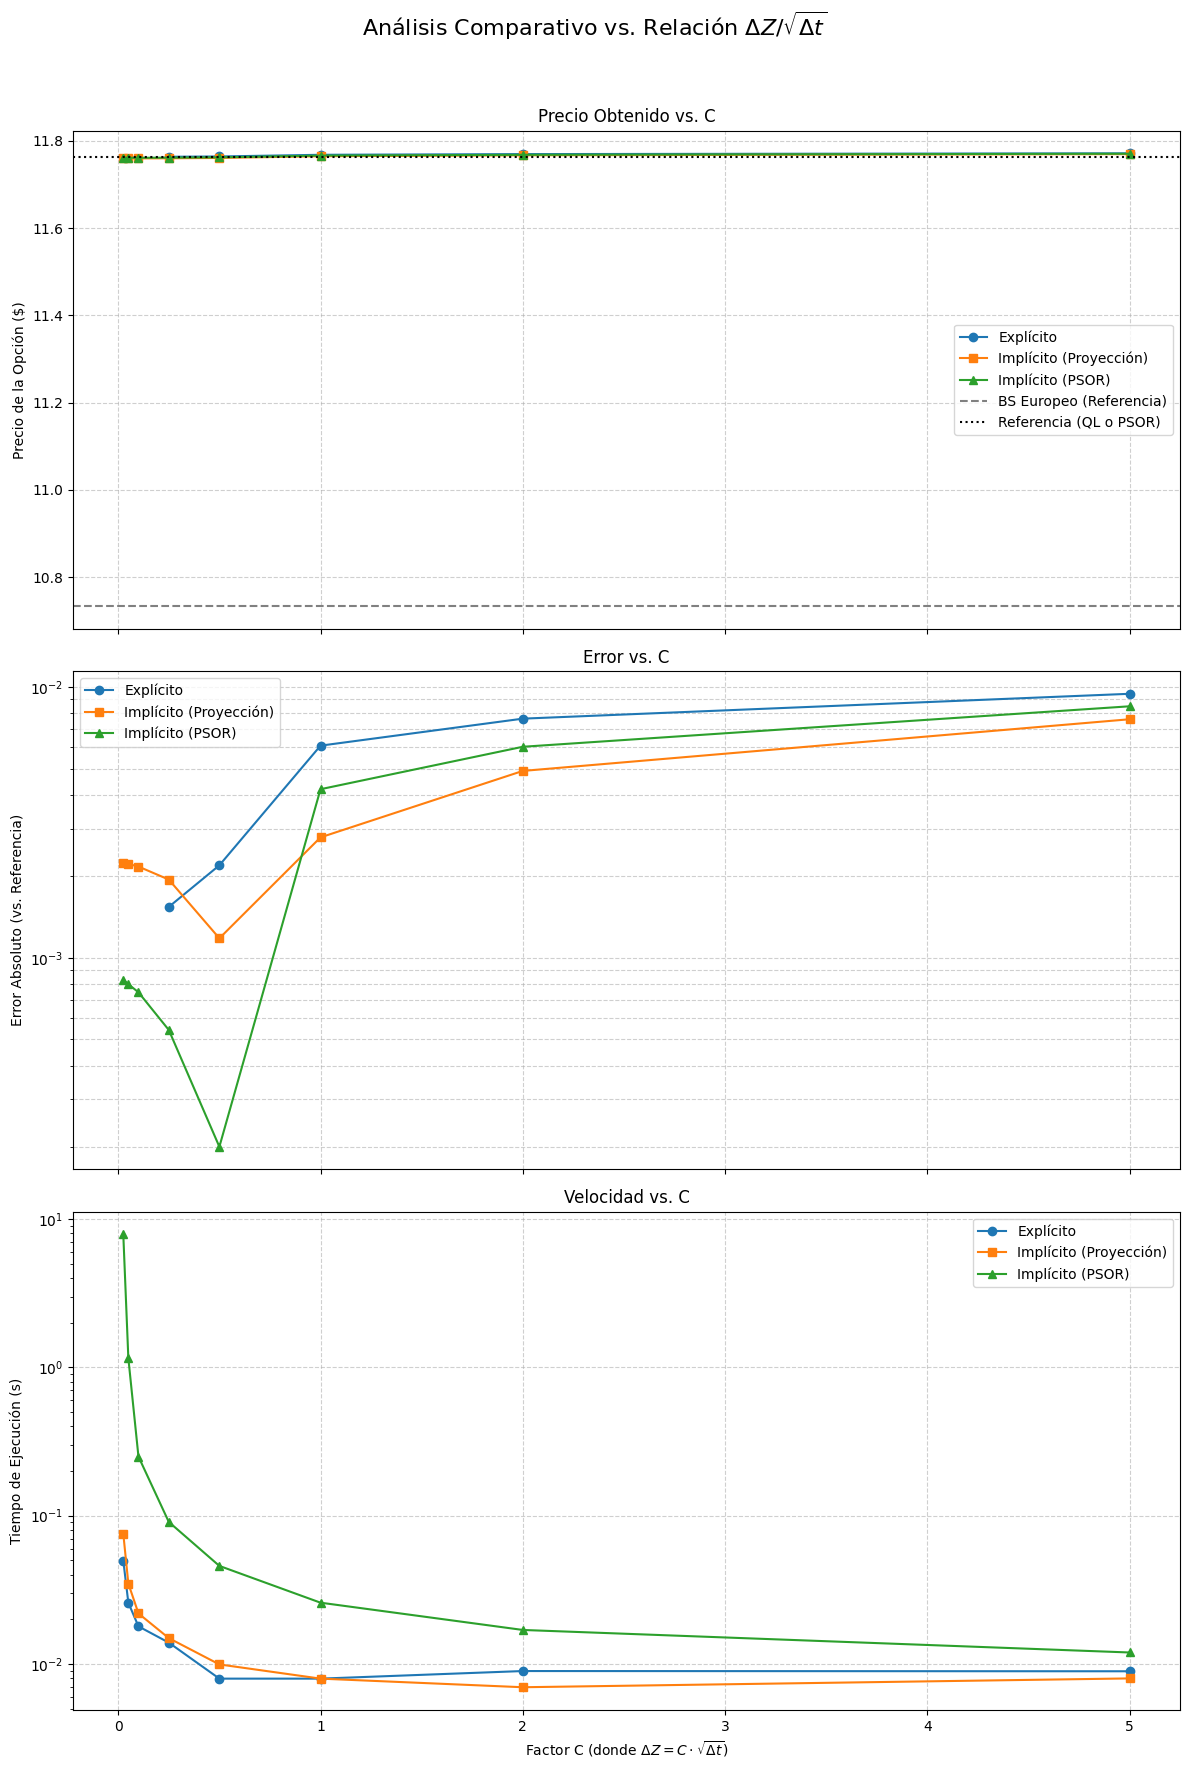

In [51]:
# 1. Funciones de referencia (placeholders y analíticas)

def exact_value(S, K, T, r, sigma, q, is_call):
    """
    Valor "exacto" vía QuantLib usando un motor de diferencias finitas (FdBlackScholesVanillaEngine).
    Si QuantLib no está instalado, intenta instalarlo automáticamente.
    Retorna un float con el NPV.
    """
    # Fecha de valoración y vencimiento
    today = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = today
    days = max(1, int(round(T * 365)))
    maturity = today + ql.Period(days, ql.Days)

    # Payoff y ejercicio (Americana por defecto)
    opt_type = ql.Option.Call if is_call else ql.Option.Put
    payoff = ql.PlainVanillaPayoff(opt_type, K)
    exercise = ql.AmericanExercise(today, maturity)
    option = ql.VanillaOption(payoff, exercise)

    # Mercado
    day_count = ql.Actual365Fixed()
    calendar = ql.NullCalendar()
    spot = ql.SimpleQuote(S)
    r_ts = ql.FlatForward(today, r, day_count)
    q_ts = ql.FlatForward(today, q, day_count)
    vol_ts = ql.BlackConstantVol(today, calendar, sigma, day_count)

    process = ql.BlackScholesMertonProcess(
        ql.QuoteHandle(spot),
        ql.YieldTermStructureHandle(q_ts),
        ql.YieldTermStructureHandle(r_ts),
        ql.BlackVolTermStructureHandle(vol_ts)
    )

    # Motor FD (grillas relativamente finas por robustez)
    engine = ql.FdBlackScholesVanillaEngine(process, 3000, 1000)
    option.setPricingEngine(engine)

    return float(option.NPV())


def black_scholes_european(S, K, T, r, sigma, q, is_call):
    """Calcula el precio de una opción Europea usando la fórmula de Black-Scholes."""
    if T <= 0:
        return np.maximum(0, S - K) if is_call else np.maximum(0, K - S)
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if is_call:
        price = (S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    else: # Put
        price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1))
        
    return price

# 2. Parámetros del experimento
K = 100.0
T = 1.0
r = 0.05
sigma = 0.2
q = 0.01
S0 = 90.0
is_call = False
american = True

# N es fijo, por lo tanto dt es fijo
N = 1000 
dt = T / N

# Rango de relaciones C = ΔZ / sqrt(Δt) para probar
# C_values = [0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0]
C_values = [0.025, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0]

# Estructuras para almacenar resultados
results = {
    'C_values': [],
    'explicit': {'price': [], 'error': [], 'time': []},
    'implicit_proj': {'price': [], 'error': [], 'time': []},
    'implicit_psor': {'price': [], 'error': [], 'time': []},
    'bs_european': {'price': [], 'error': [], 'time': []}
}

# 3. Bucle de simulación
print("Iniciando simulación comparativa...")
xmin, xmax = _domain_from_L(K, sigma, T, L=6.0)

for C in C_values:
    results['C_values'].append(C)
    
    # Calcular M basado en la relación C = dx / sqrt(dt)
    dx = C * np.sqrt(dt)
    M = int(np.ceil((xmax - xmin) / dx))
    
    
    print(f"  Ejecutando para C = {C:.2f} (M={M})...")

    # --- Método Explícito --- (si diverge, advertencia y NaN)
    try:
        start_time = time.time()
        S_vec, V_vec = solve_pde(K, T, r, sigma, q=q, is_call=is_call, american=american, M=M, N=N, method='explicit')
        exec_time = time.time() - start_time
        price = np.interp(S0, S_vec, V_vec)
        # Validaciones de estabilidad y cotas
        finite = np.all(np.isfinite(V_vec)) and np.isfinite(price)
        if not finite:
            print(f"    [WARN] Explícito divergente para C={C:.2f}. Se omite el dato.")
            results['explicit']['price'].append(np.nan)
            results['explicit']['time'].append(exec_time)
        else:
            results['explicit']['price'].append(price)
            results['explicit']['time'].append(exec_time)
    except Exception as e:
        print(f"    [WARN] Explícito falló para C={C:.2f}: {e}")
        results['explicit']['price'].append(np.nan)
        results['explicit']['time'].append(np.nan)

    # --- Método Implícito (Proyección) ---
    start_time = time.time()
    S_vec, V_vec = solve_pde(K, T, r, sigma, q=q, is_call=is_call, american=american, M=M, N=N, method='implicit', american_method='projection')
    exec_time = time.time() - start_time
    price = np.interp(S0, S_vec, V_vec)
    results['implicit_proj']['price'].append(price)
    results['implicit_proj']['time'].append(exec_time)

    # --- Método Implícito (PSOR) ---
    start_time = time.time()
    S_vec, V_vec = solve_pde(K, T, r, sigma, q=q, is_call=is_call, american=american, M=M, N=N, method='implicit', american_method='psor')
    exec_time = time.time() - start_time
    price = np.interp(S0, S_vec, V_vec)
    results['implicit_psor']['price'].append(price)
    results['implicit_psor']['time'].append(exec_time)
    
    # --- Black-Scholes Europeo (Referencia) ---
    price_bs = black_scholes_european(S0, K, T, r, sigma, q, is_call)
    results['bs_european']['price'].append(price_bs)
    results['bs_european']['time'].append(0)

# Calcular errores
ql_exact = exact_value(S0, K, T, r, sigma, q, is_call)
reference_price = ql_exact if (ql_exact is not None) else np.nanmean(results['implicit_psor']['price'])
if ql_exact is None:
    print("Nota: QuantLib no disponible; usando el promedio de PSOR como referencia.")
else:
    print(f"Valor de referencia (QuantLib FD): {reference_price:.8f}")

for method in ['explicit', 'implicit_proj', 'implicit_psor', 'bs_european']:
    # error = NaN si el precio del método es NaN
    errs = []
    for p in results[method]['price']:
        if np.isnan(p):
            errs.append(np.nan)
        else:
            errs.append(abs(p - reference_price))
    results[method]['error'] = errs

print("Simulación completada.")

# 4. Generación de Gráficos
x_axis_data = results['C_values']
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
fig.suptitle('Análisis Comparativo vs. Relación $\\Delta Z / \\sqrt{\\Delta t}$', fontsize=16)

# Gráfico 1: Precio Obtenido
ax1.plot(x_axis_data, results['explicit']['price'], 'o-', label='Explícito')
ax1.plot(x_axis_data, results['implicit_proj']['price'], 's-', label='Implícito (Proyección)')
ax1.plot(x_axis_data, results['implicit_psor']['price'], '^-', label='Implícito (PSOR)')
ax1.axhline(y=results['bs_european']['price'][0], color='grey', linestyle='--', label='BS Europeo (Referencia)')
ax1.axhline(y=reference_price, color='k', linestyle=':', label='Referencia (QL o PSOR)')
ax1.set_ylabel('Precio de la Opción ($)')
ax1.set_title('Precio Obtenido vs. C')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# Gráfico 2: Error
ax2.plot(x_axis_data, results['explicit']['error'], 'o-', label='Explícito')
ax2.plot(x_axis_data, results['implicit_proj']['error'], 's-', label='Implícito (Proyección)')
ax2.plot(x_axis_data, results['implicit_psor']['error'], '^-', label='Implícito (PSOR)')
ax2.set_ylabel('Error Absoluto (vs. Referencia)')
ax2.set_title('Error vs. C')
ax2.set_yscale('log')
ax2.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.legend()

# Gráfico 3: Velocidad
ax3.plot(x_axis_data, results['explicit']['time'], 'o-', label='Explícito')
ax3.plot(x_axis_data, results['implicit_proj']['time'], 's-', label='Implícito (Proyección)')
ax3.plot(x_axis_data, results['implicit_psor']['time'], '^-', label='Implícito (PSOR)')
ax3.set_xlabel('Factor C (donde $\\Delta Z = C \\cdot \\sqrt{\\Delta t}$)')
ax3.set_ylabel('Tiempo de Ejecución (s)')
ax3.set_title('Velocidad vs. C')
ax3.set_yscale('log')
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()